In [1]:
import datetime
from typing import List
import requests
import asyncio
import nest_asyncio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import BytesIO
from zipfile import ZipFile
from aiohttp import ClientSession, TCPConnector
from statsmodels.tsa.stattools import adfuller
from scipy import stats
import nest_asyncio
nest_asyncio.apply()

plt.stye.use('fast')
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['lines.linewidth'] = 1


def binance_ticker_historical(symbol: str = 'BTC', interval: str = '4h', number_of_days: int = 100, cols: List[str] = ['Close']) -> pd.DataFrame:
    '''Gather historical data of a crypto token over range (today - number_of_days,today)

    This function will return a pandas DataFrame indexed by date with standard financial metrics:
    'Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time', 'Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume'

    this uses the binance data.binance.vision url because USA users are blocked from accessing binance python API
    I used zipfile to unzip the files and combined them using pandas

    parameters
    ----------
    symbol: str 
        a crypto token ticker
        default: BTC'
    interval: str
        a string interval, supported are 12h, 15m, 1d, 1h, 1m, 1s, 2h, 30m, 3m, 4h, 5m, 6h, 8h
        default: '4h'
    number_of_days: int
        number of days of data you want
        default: 100
    cols: List[str]
        the labels of the columns you want
        default: ['Close']
    '''
    columns = ['Open time',
               'Open',
               'High',
               'Low',
               'Close',
               'Volume',
               'Close time',
               'Quote asset volume',
               'Number of trades',
               'Taker buy base asset volume',
               'Taker buy quote asset volume',
               'Ignore'
               ]
    base_url = 'https://data.binance.vision' + \
        f'/data/spot/daily/klines/{symbol}USDT/{interval}/{symbol}USDT-{interval}'
    today = datetime.datetime.today()
    date_list = [today - datetime.timedelta(days=i)
                 for i in range(number_of_days)]
    prices_df = dict.fromkeys(date_list)

    for date in date_list:
        kucoin_prices = requests.get(
            base_url + f'-{date.year}-{date.month:02}-{date.day:02}.zip')
        if kucoin_prices.status_code != 200:
            continue
        tmp = ZipFile(BytesIO(kucoin_prices.content))
        name = tmp.namelist()[0]
        prices_df[date] = pd.read_csv(
            tmp.open(name), names=columns)[cols]
    return prices_df


async def async_binance_ticker_historical(symbol: str = 'BTC', interval: str = '4h', number_of_days: int = 100, cols: List[str] = ['Close','Close time']) -> pd.DataFrame:
    '''Gather historical data of a crypto token over range (today - number_of_days,today)

    This function will return a pandas DataFrame indexed by date with standard financial metrics:
    'Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time', 'Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume'

    this uses the binance data.binance.vision url because USA users are blocked from accessing binance python API
    I used zipfile to unzip the files and combined them using pandas
    improved version of above binance_get_all function using aiohttp

    parameters
    ----------
    symbol: str 
        a crypto token ticker
        default: BTC'
    interval: str
        a string interval, supported are 12h, 15m, 1d, 1h, 1m, 1s, 2h, 30m, 3m, 4h, 5m, 6h, 8h
        default: '4h'
    number_of_days: int
        number of days of data you want
        default: 100
    cols: List[str]
        the labels of the columns you want, have to pass 'Close time' 
        default: ['Close','Close time']
    '''
    columns = ['Open time',
               'Open',
               'High',
               'Low',
               'Close',
               'Volume',
               'Close time',
               'Quote asset volume',
               'Number of trades',
               'Taker buy base asset volume',
               'Taker buy quote asset volume',
               'Ignore'
               ]
    base_url = 'https://data.binance.vision'
    symbol = base_url + \
        f'/data/spot/daily/klines/{symbol}USDT/{interval}/{symbol}USDT-{interval}'
    today = datetime.datetime.today()
    date_list = [today - datetime.timedelta(days=i)
                 for i in range(1, number_of_days)]
    async with ClientSession(connector=TCPConnector(limit=25)) as session:
        tasks = []
        for date in date_list:
            url = symbol + f'-{date.year}-{date.month:02}-{date.day:02}.zip'
            task = bytes_from_req(url, session)
            tasks.append(task)
        bytes = await asyncio.gather(*tasks)
        bytes = [b for b in bytes if b != '']
        tasks = []
        for b in bytes:
            tasks.append(zip_bytes_to_csv(b, columns, cols))
        csvs = await asyncio.gather(*tasks)
        if len(csvs) < 1:
            return None
        df = pd.DataFrame(np.vstack(csvs), columns=cols)
        df.index = pd.to_datetime(
            df['Close time'], unit='ms').dt.strftime('%Y-%m-%d %H:%M:%S')
        df.drop(['Close time'], axis=1, inplace=True)
        return df


def get_top_n_by_vol_kucoin_data(n: int = 10, days: int = 10, interval: str = '1h') -> pd.DataFrame:
    '''get the price data for the top n coins on kucoin by volume

    returns a pandas dataframe indexed by date with columns being n different crypto token historical prices
    uses async_binance_ticker_historical function to async gather individual data, and then concatenates it 

    parameters
    ----------
    n: int 
        number of kucoin tickers you want, in order of volume descending
        default: 10
    days: int
        number of days of data
        default: 10
    interval:
        interval of price data, supported are 12h, 15m, 1d, 1h, 1m, 1s, 2h, 30m, 3m, 4h, 5m, 6h, 8h
        default: '4h'
    ----------
    '''
    data = requests.get(
        'https://api.kucoin.com/api/v1/market/allTickers').json()['data']['ticker']
    df = pd.DataFrame.from_dict(data)
    df['tickers'] = df.symbol.str.split('-').apply(lambda x: x[0])
    df['USDT'] = df.symbol.str.split('-').apply(lambda x: x[1] == 'USDT')
    df = df[df.USDT]
    df.volValue = df.volValue.astype(float)
    top_100_by_vol_tickers = df.sort_values('volValue', ascending=False)[
        'tickers'][:n].tolist()
    vol_100_data = [async_binance_ticker_historical(
        t, interval, days) for t in top_100_by_vol_tickers]
    results = asyncio.run(asyncio.gather(*vol_100_data))
    indices = [i for i, x in enumerate(results) if x is None]
    for i in indices[::-1]:
        del top_100_by_vol_tickers[i]
    return pd.concat(results, axis=1, keys=top_100_by_vol_tickers)


async def bytes_from_req(url:str, session:ClientSession):
    '''asynchronously try to get a url and return bytes content'''
    async with session.get(url) as response:
        if response.status == 200:
            kucoin_prices = await response.read()
            return kucoin_prices
        return ''


async def zip_bytes_to_csv(zip:bytes, cols:List[str], target:List[str]):
    '''load a byte stream of a zipped .csv file into a pandas dataframe and return target columns'''
    zip = ZipFile(BytesIO(zip))
    name = zip.namelist()[0]
    return pd.read_csv(
        zip.open(name), names=cols
    )[target]


def stationarity_test(a:str, b:str, df:pd.DataFrame):
    '''check the spread of two time series for stationarity using an an Augmented Dickey Fuller test

    this is used to check if two series of price data a,b have a stationary spread,
    which can be leveraged in a mean-reversion pairs trading strategy
    to do so:
    1.) estimate the parameters of a linear regession fitting a = \mu + \gamma * b
    2.) calculate the residuals 
    3.) check the residuals for stationarity using ADF test
    
    parameters
    ---------
    a,b : str
        labels of the columns in df you are testing 
    df : pd.DataFrame
    ---------
    '''
    assert a in df.columns and b in df.columns, 'one of the labels passed is not in the df'
    data = df[[a, b]]
    X = np.vstack([np.ones(len(data)), data[a]]).T
    y = data[b].T
    mu, gamma = np.dot(np.linalg.pinv(X), y)
    residuals: pd.DataFrame = data[a] - gamma * data[b] - mu
    return adfuller(residuals, regression='ct')[1], residuals

def cmp(a:int, b:int):
    return (a > b) ^ (a < b)


def check_crossing(p1:float, p2:float,val = 0):
    return (p1 < val and p2 > val) or (p1 > val and p2 < val)


def profit_check(df:pd.DataFrame, s:float):
    openLeg = 0.0
    profit = 0.0
    trades = []
    exits = []
    prev = cmp(df[0], 0)
    for i, spread in enumerate(df):
        if (spread > s or spread < -s) and openLeg == 0.0:
            openLeg = spread
            trades.append(i)
        if check_crossing(prev, spread):
            exits.append(i-1)
            profit += abs(openLeg)
            openLeg = 0.0
        prev = spread
    return profit, trades, exits


def get_trades(df:pd.DataFrame, threshold:float):
    '''get indices of trades given a spread and a threshold'''
    long = df.mean()
    trades = []
    exits = []
    prev = 0
    curr_trade = False
    for i, spread in enumerate(df):
        if abs(long - spread) > threshold and curr_trade == False:
            trades.append(i)
            curr_trade = True
        elif curr_trade == True:
            if ((spread > long and  prev < long) or (spread < long and prev > long)):
                exits.append(i)
                curr_trade = False
        prev = (spread)
    return trades, exits


def eval_trades(a:str, b:str, spread:pd.DataFrame, df:pd.DataFrame, trades):
    '''simulate long and short entries given log price spread,trades,real prices and pair of tokens
    
    
    this goes through trades generated by get_trades, and evals the long/short
    i do this by entering trades at short/long depending on spread and looking for spread mean crossings to exit
    '''
    prev = 0
    profit = 0.0
    profits = []
    for trade in trades:
        undervalued_a = (spread[trade] < spread.mean())
        if undervalued_a:
            long, short = df[a][trade], df[b][trade]
        else:
            short, long = df[a][trade], df[b][trade]
        i = trade + 1
        while (i < len(df) - 1 and not check_crossing(prev, spread[i],spread.mean())):
            prev = spread[i]
            i += 1
        if undervalued_a:
            profit += (df[a][i-1] - long) + (short - df[b][i-1])
        else:
            profit += (df[b][i-1] - long) + (short - df[a][i-1])
        profits.append(profit)

    return profits


def spread_entry_plot(a, b, df, s, ax, use_ewm=False):
    '''plot entry points for a pair of tokens given a threshold'''
    test_data = df[a] - df[b]
    trades, exits = get_trades(test_data, s)
    print(trades,exits)
    ax.set_xticklabels([])
    ax.tick_params(bottom=False)
    ax.set_xlabel(r'$t$')
    ax.plot(test_data.index, test_data)
    ewm = test_data.ewm(span=len(test_data)).mean()
    if use_ewm:
        ax.plot(test_data.index, ewm)
        ax.plot(test_data.index, ewm + s)
        ax.plot(test_data.index, ewm - s)
        ax.scatter(exits, ewm[exits], marker='+', c='red')
    else:
        ax.axhline(test_data.mean() - s, c='green')
        ax.axhline(test_data.mean())
        ax.axhline(test_data.mean() + s, c='green')
        ax.scatter(exits, [test_data.mean()] * len(exits), marker='+', c='red',linewidths=4)
    ax.scatter(trades, test_data[trades], marker=(3, 0, 270), c='red')
    ax.set_title(f'Spread deviation entrypoints with s = {s} for {a}/{b}')


def log_prices_with_exits(a, b, df, s, ax):
    spread = df[a] - df[b]
    profit, trades, exits = profit_check(spread, s)
    ax.plot(df[a].index, df[a])
    ax.plot(df[b].index, df[b])
    ax.scatter(df[a][trades].index, df[b][trades], marker=(3, 0, 270), c='red')
    ax.scatter(df[b][trades].index, df[b][trades], marker=(3, 0, 270), c='red')
    ax.scatter(df.index[exits], df[a][exits], marker='_', c='green')
    ax.set_title(
        f'{a} and {b} log normalized prices with trades at spread = {s}')


def prices_with_exits(a, b, df, norm_df, s, ax):
    spread = df[a] - df[b]
    trades, exits = get_trades(spread, s)
    ax.plot(norm_df[a].index, norm_df[a])
    ax.plot(norm_df[b].index, norm_df[b])
    ax.scatter(norm_df.index[exits], norm_df[a][exits])
    ax.set_title(
        f'{a} and {b} prices with trades at spread = {s}')

def cdf_profit_plot(a, b, df, ax=None, min_trades=1, min_exits=1):
    '''returns spread with largest profit of different trading spreads for a pair of tickers,optional plots
    
    given T(n) = number of days where spread is above/below a threshold (entries), this plots (cdf(n) * T(n) * cdf(1-n))
    returns the spread with largest profit

    parameters
    ---------
    a,b : str
        labels of the tickers in df you are plotting
    df : pd.DataFrame
    ax: plt.Axes
        optional arg for the plot
    min_trades: int
        min trades needed for a threshold, not sure if working correctly
    min_exits: int
        min exits needed for a threshold, not sure if working correctly
    ---------
    '''
    a1, b1 = df[a], df[b]
    spread = a1 - b1
    thresholds = np.linspace(0.0001, max(abs(spread)), 10)
    cdfs = []
    plots = []
    for threshold in thresholds:
        trades, exits = get_trades(spread,threshold)
        profit = sum(eval_trades(a,b,spread,df,trades))
        if len(trades) >= min_trades and len(exits) >= min_exits:
            plots.append(threshold)
            cdfs.append(stats.norm.cdf(1-threshold) * threshold * len(trades))
    if len(cdfs) == 0:
        return -1
    top_profit = np.argmax(cdfs)
    if ax is None:
        return plots[top_profit]
    ax.plot(plots, cdfs)

    ax.scatter(plots[top_profit], max(cdfs), marker='v')
    ax.annotate(f'   {plots[top_profit]:.4f}', xy=(plots[top_profit], max(cdfs)))
    ax.set_title(f'{a}/{b} spread')
    return plots[top_profit]
        


def sim_actual_long_short(a, b, df, trades):
    real_a, real_b = df[a], df[b]
    spread = real_a - real_b
    short = long = 0.0
    prof = 0.0
    for trade in trades:
        curr = spread[trade]
        if curr < spread.mean():
            l, r = real_a, real_b
        elif curr > spread.mean():
            l, r = real_b, real_a
        else:
            continue
        short = l[trade]
        long = r[trade]
        i = trade
        while (i < len(spread) and spread[i] < 0):
            i += 1
        if i == len(spread):
            break
        prof += (short - l[i]) + (long + (r[i] - long))
    return prof


AttributeError: module 'matplotlib.pyplot' has no attribute 'stye'

In [ ]:
kucoin_prices = get_top_n_by_vol_kucoin_data(100,100,interval='4h').sort_index().dropna(thresh=2,axis=1)
kucoin_prices = kucoin_prices[[c for c in kucoin_prices if kucoin_prices[c].isnull().sum() < 2]].dropna(axis=0)
kucoin_prices.columns = kucoin_prices.columns.droplevel(1)


In [ ]:
normalized_kucoin_prices = kucoin_prices.copy()
for column in kucoin_prices.columns:
    normalized_kucoin_prices[column] = np.log10(kucoin_prices[column] + 0.001)
    normalized_kucoin_prices[column] = kucoin_prices[column]/kucoin_prices[column][0]
normalized_kucoin_prices.head()

,BTC,ETH,SOL,ACH,MATIC,XRP,AGIX,FIL,STX,CFX,...,LINA,REN,COCOS,FXS,CHZ,MAGIC,SLP,RUNE,QNT,C98
Close time,,,,,,,,,,,,,,,,,,,,,
2022-11-15 03:59:59,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2022-11-15 07:59:59,1.001282,1.007791,1.019718,0.996929,1.063250,0.998825,1.001504,1.030385,1.006881,1.015220,...,0.986239,1.013389,1.007401,0.997722,1.000000,1.003881,0.998264,1.005435,1.063705,1.004854
2022-11-15 11:59:59,0.997537,1.003048,1.023239,0.985670,1.045256,1.005450,1.005263,1.029571,1.004587,1.002998,...,0.979358,1.006157,1.009868,1.003986,1.001618,1.023011,1.003906,1.008696,1.022590,1.000000
2022-11-15 15:59:59,1.009747,1.006223,1.010563,1.019447,1.040894,1.011434,1.018797,1.060770,1.020642,1.019140,...,0.997706,1.041124,1.037829,1.004556,1.017799,1.056002,1.007812,1.018478,0.977108,1.007282
2022-11-15 19:59:59,1.002123,1.000589,1.009859,1.011259,1.020720,1.015922,1.024060,1.043950,1.004587,0.999539,...,0.972477,1.011476,1.022204,0.975513,0.996764,1.041309,0.999566,1.009783,0.974247,0.992718


In [ ]:
rough_cointegration_values = []
for i,column1 in enumerate(normalized_kucoin_prices.columns):
    for column2 in normalized_kucoin_prices.columns[i + 1:]:
        cointegration_value = np.sum(np.square(normalized_kucoin_prices[column1] - (normalized_kucoin_prices[column2])))
        rough_cointegration_values.append((cointegration_value,column1,column2))
coints = pd.DataFrame(rough_cointegration_values,columns=['rough_coint','ticker_A','ticker_B'])
coints = coints[coints['rough_coint'] != 0.0]
top_20 = coints.sort_values('rough_coint',ascending=True)[:20]
top_20.head()

,rough_coint,ticker_A,ticker_B
907,0.987613,APT,XLM
724,1.213599,DOT,APT
392,1.650647,FIL,LDO
1315,1.693444,ATOM,FLOW
741,1.844850,DOT,XLM


In [ ]:
top_100_cointegration = coints.sort_values('rough_coint',ascending=True)[:100]
stationarity = []
for i,(_,a,b) in top_100_cointegration.iterrows():
    p_value, residuals = stationarity_test(a,b,normalized_kucoin_prices)
    stationarity.append(p_value)
top_100_cointegration['stationarity'] = stationarity


In [ ]:
top_tradable_spreads = top_100_cointegration.sort_values('stationarity').reset_index(drop=True)
top_tradable_spreads.head(5)

,rough_coint,ticker_A,ticker_B,stationarity
0,5.793017,XTZ,FXS,0.000797
1,0.987613,APT,XLM,0.001603
2,4.187802,KDA,INJ,0.007815
3,4.380590,MANA,APE,0.007850
4,1.979267,RNDR,GLMR,0.021511


-0.25219999999999854
[123, 302, 361, 386, 432, 510, 573] [247, 358, 370, 410, 509, 514]


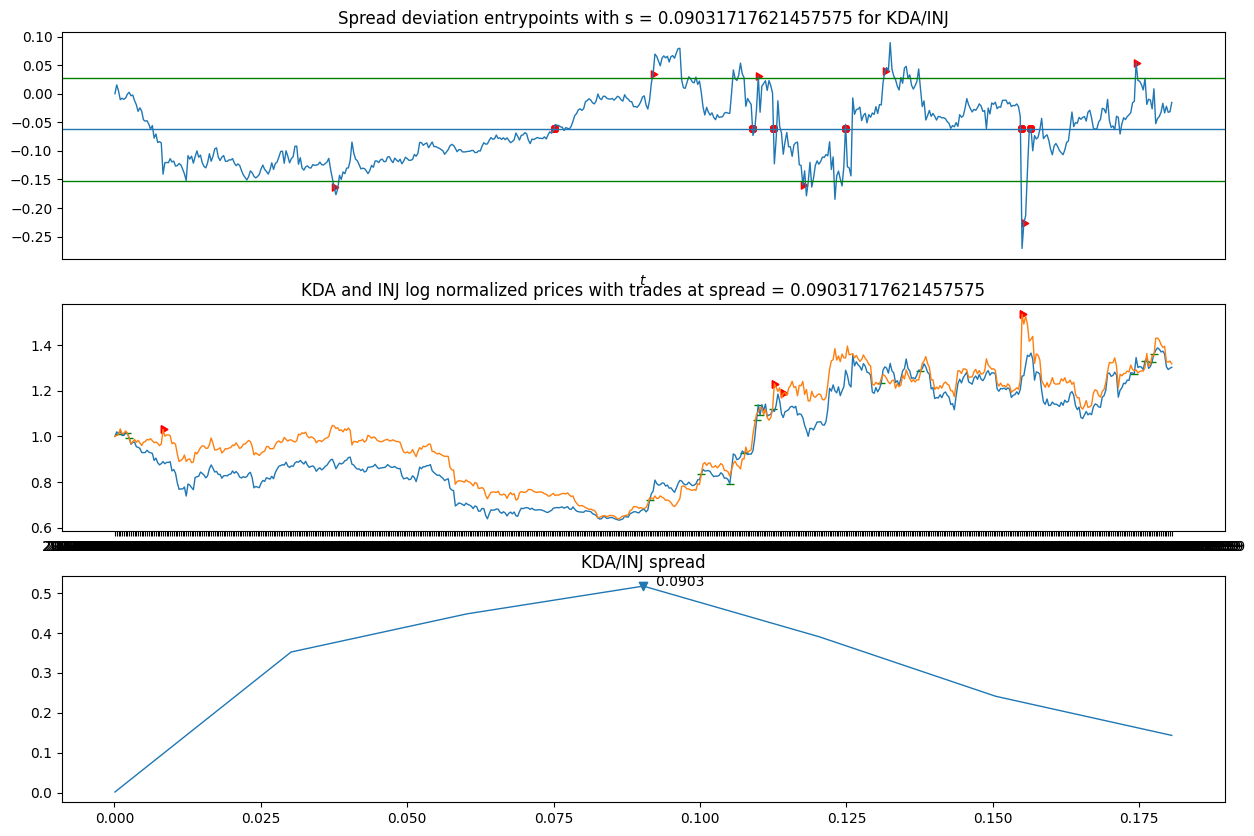

In [ ]:

fig,ax = plt.subplots(3,1)

a,b = top_tradable_spreads.iloc[2,:][['ticker_A','ticker_B']]
spread_threshold = cdf_profit_plot(a,b,normalized_kucoin_prices,ax[2])
spread = normalized_kucoin_prices[a] - normalized_kucoin_prices[b]
profits = eval_trades(a,b,spread,kucoin_prices,get_trades(spread,spread_threshold)[0])
print(sum(profits))
spread_entry_plot(a,b,normalized_kucoin_prices,spread_threshold,ax[0])
log_prices_with_exits(a,b,normalized_kucoin_prices,spread_threshold,ax[1])




[123, 302, 361, 386, 432, 510, 573] [247, 358, 370, 410, 509, 514]


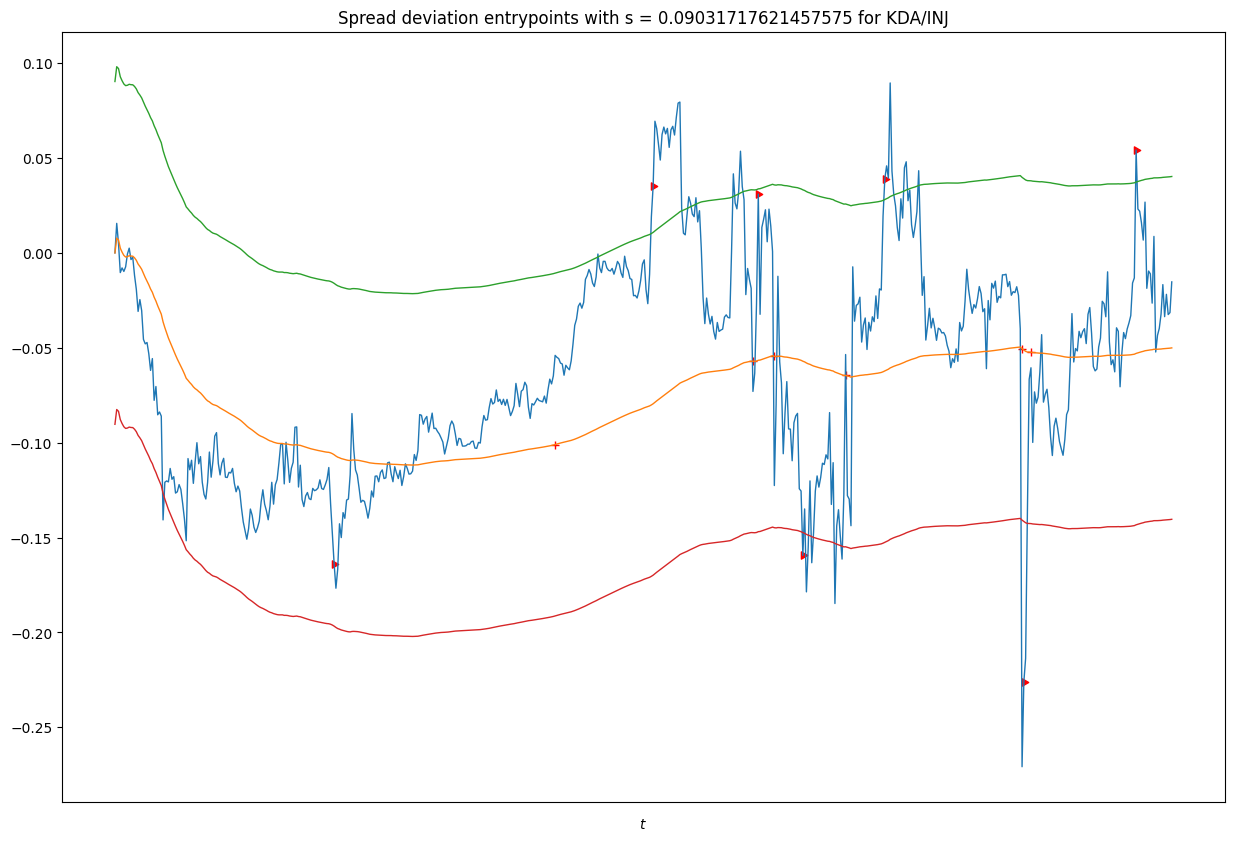

In [ ]:
fig,ax = plt.subplots()
spread_entry_plot(a,b,normalized_kucoin_prices,spread_threshold,ax,use_ewm=True)

In [ ]:
def find_threshold_eval_trades(a,b,prices,norm_prices):
    threshold = cdf_profit_plot(a,b,prices)
    spread = norm_prices[a] - norm_prices[b]
    trades,exits = get_trades(spread,threshold)
    profits = eval_trades(a,b,spread,kucoin_prices,trades)
    return sum(profits)

top_tradable_spreads = top_100_cointegration.sort_values('stationarity').reset_index(drop=True)
profs = []
for i,(_,a,b,_) in top_tradable_spreads.iterrows():
    profs.append(find_threshold_eval_trades(a,b,kucoin_prices,normalized_kucoin_prices))
top_tradable_spreads['profit'] = profs
top_tradable_spreads = top_tradable_spreads[top_tradable_spreads.stationarity < 0.1]
top_profitable = top_tradable_spreads.sort_values('profit',ascending=False)
top_profitable.head()

,rough_coint,ticker_A,ticker_B,stationarity,profit
13,4.624390,APE,FLOW,0.094039,53355.8510
3,4.380590,MANA,APE,0.007850,488.0450
0,5.793017,XTZ,FXS,0.000797,20.3149
8,3.896336,XLM,FLOW,0.043007,1.2310
14,4.541537,XRP,FLOW,0.094615,0.7765


[0, 20, 61, 111, 358, 413, 420, 439, 506] [8, 27, 91, 227, 402, 418, 432, 456]


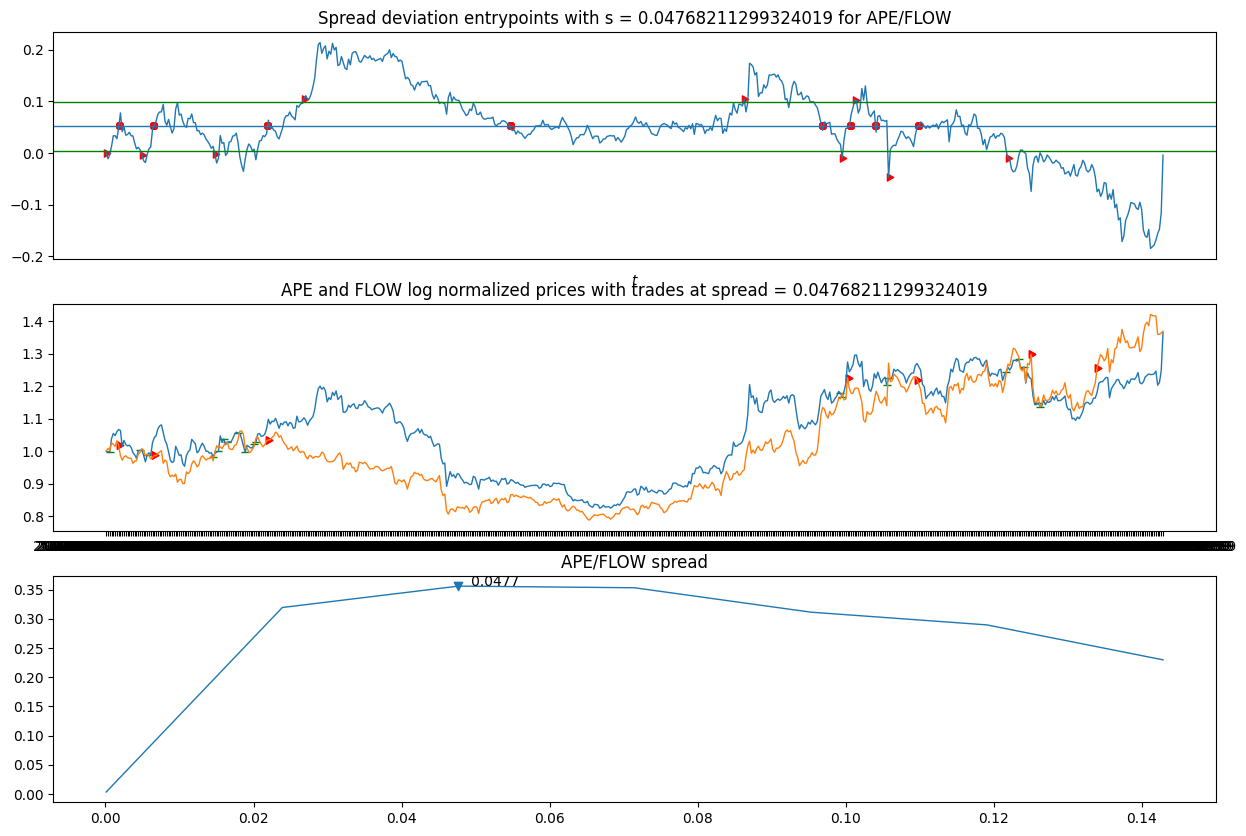

In [ ]:
a,b = top_profitable.iloc[0,:][['ticker_A','ticker_B']]
fig,ax = plt.subplots(3,1)
s = cdf_profit_plot(a,b,normalized_kucoin_prices,ax[2])
spread_entry_plot(a,b,normalized_kucoin_prices,s,ax[0])
log_prices_with_exits(a,b,normalized_kucoin_prices,s,ax[1])

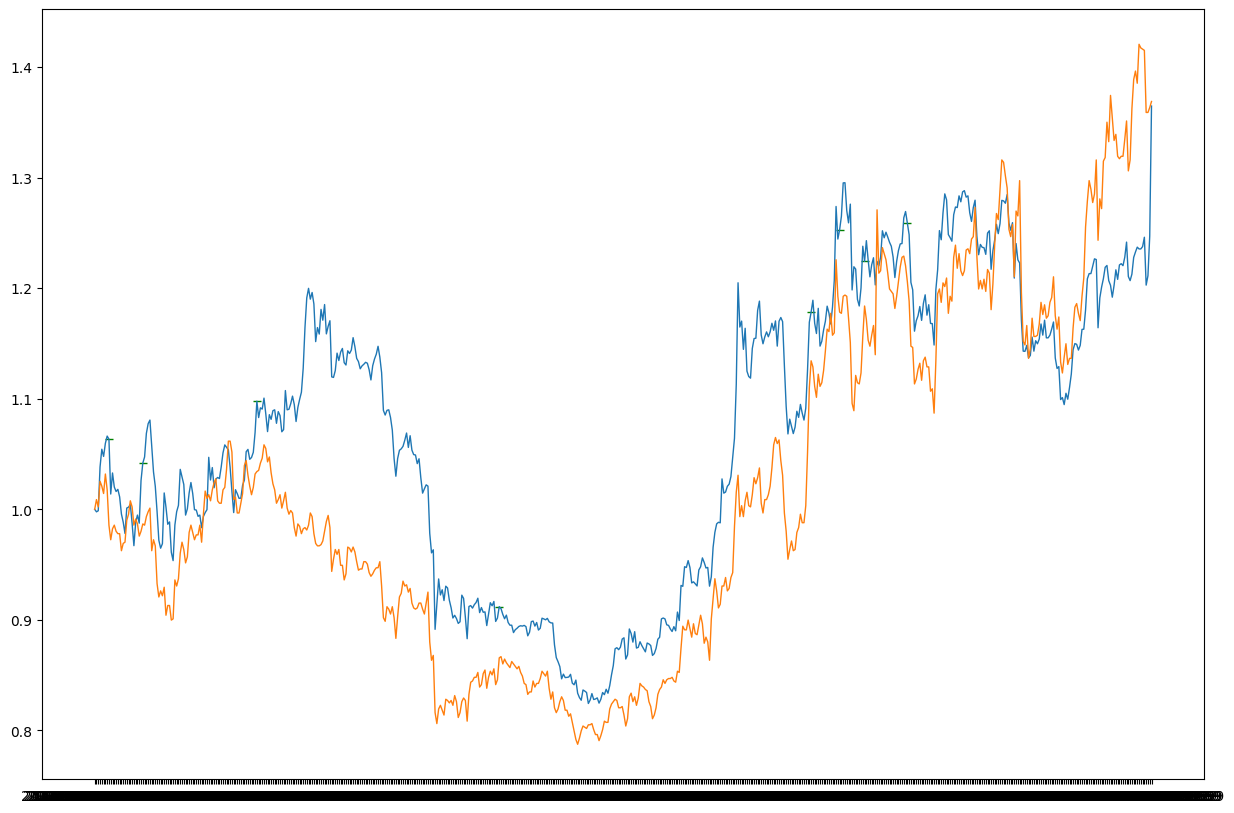

In [ ]:
fig,ax = plt.subplots()
ax.plot(kucoin_prices.index,normalized_kucoin_prices[a],linewidth=1)
ax.plot(kucoin_prices.index,normalized_kucoin_prices[b],linewidth=1)
trades,exits = get_trades(normalized_kucoin_prices[a] - normalized_kucoin_prices[b],s)
ax.scatter(kucoin_prices.index[exits],normalized_kucoin_prices[a][exits],marker='_',c='g')
